# Electricity System Optimization

This notebook contains two optimization problems:
1. **Single-Year Optimization** - Minimize generation and upgrade costs for one year
2. **Multi-Year Optimization** - 20-year planning with budget constraints and load growth

In [40]:

#Input data we are making a electricity system with 3 generators and 3 demands and 8 buses in total
#they should not be slack buses
buses = {
    'Bus1': {'type': 'generator'},
    'Bus2': {'type': 'generator'},
    'Bus3': {'type': 'generator'},
    'Bus4': {'type': 'generator'},
    'Bus5': {'type': 'load'},
    'Bus6': {'type': 'generator'},
    'Bus7': {'type': 'load'},
    'Bus8': {'type': 'load'},
}
generators = {
    'Gen1': {'bus': 'Bus1', 'capacity': 300, 'cost': 20},
    'Gen2': {'bus': 'Bus2', 'capacity': 150, 'cost': 10},
    'Gen3': {'bus': 'Bus3', 'capacity': 600, 'cost': 30},
    'Gen4': {'bus': 'Bus4', 'capacity': 0, 'cost': 0},
    'Gen5': {'bus': 'Bus6', 'capacity': 0, 'cost': 0},
}
loads = {
    'Load5': {'bus': 'Bus5', 'demand': 80},
    'Load7': {'bus': 'Bus7', 'demand': 120},
    'Load8': {'bus': 'Bus8', 'demand': 150},
}
lines = {
    ('Bus1', 'Bus4'): {'capacity': 50},
    ('Bus1', 'Bus2'): {'capacity': 50},
    ('Bus2', 'Bus3'): {'capacity': 70},
    ('Bus2', 'Bus5'): {'capacity': 50},
    ('Bus3', 'Bus6'): {'capacity': 90},
    ('Bus4', 'Bus7'): {'capacity': 80},
    ('Bus5', 'Bus7'): {'capacity': 70},    
    ('Bus5', 'Bus6'): {'capacity': 65},
    ('Bus6', 'Bus8'): {'capacity': 50},  
    ('Bus7', 'Bus8'): {'capacity': 30},
}  
#Cost for increasing line capacities
line_upgrade_cost = 5  # Cost per unit increase in line capacity 

#write this model 




## Input Data

Defining the network topology, generators, loads, and transmission lines.

In [41]:
import gurobipy as gp
from gurobipy import GRB
# Create a new model
model = gp.Model("electricity_system")

# Create variables for generator outputs
gen_vars = {}
for gen, data in generators.items():
    gen_vars[gen] = model.addVar(lb=0, ub=data['capacity'], name=f"GenOutput_{gen}")

# Create variables for line flows and capacity upgrades (one per undirected line)
line_vars = {}
line_upgrade_vars = {}
for (bus_from, bus_to), data in lines.items():
    cap = data['capacity']
    # single flow var for the undirected line: allow negative values for reverse flow
    line_vars[(bus_from, bus_to)] = model.addVar(name=f"LineFlow_{bus_from}_{bus_to}")
    # single upgrade var (non-negative) for that same undirected line
    line_upgrade_vars[(bus_from, bus_to)] = model.addVar(name=f"LineUpgrade_{bus_from}_{bus_to}")

# Add capacity constraints: |flow| <= capacity + upgrade
for (bus_from, bus_to), data in lines.items():
    cap = data['capacity']
    f = line_vars[(bus_from, bus_to)]
    u = line_upgrade_vars[(bus_from, bus_to)]
    model.addConstr(f <= cap + u, name=f"CapPos_{bus_from}_{bus_to}")
    model.addConstr(f >= - (cap + u), name=f"CapNeg_{bus_from}_{bus_to}")

# Create constraints for power balance at each bus
for bus, data in buses.items():
    inflow = gp.LinExpr()
    outflow = gp.LinExpr()
    generation = gp.LinExpr()
    demand = gp.LinExpr()
    
    # Sum inflows and outflows from lines
    for (bus_from, bus_to), var in line_vars.items():
        if bus_to == bus:
            inflow += var
        if bus_from == bus:
            outflow += var
    
    # Sum generation at this bus
    for gen, gen_data in generators.items():
        if gen_data['bus'] == bus:
            generation += gen_vars[gen]
    
    # Sum demand at this bus
    for load, load_data in loads.items():
        if load_data['bus'] == bus:
            demand += load_data['demand']
    
    # Power balance constraint
    model.addConstr(generation + inflow == demand + outflow, name=f"PowerBalance_{bus}")
# Set objective: minimize generation cost and line upgrade cost
gen_cost = gp.quicksum(gen_vars[gen] * data['cost'] for gen, data in generators.items())
upgrade_cost = gp.quicksum(line_upgrade_vars[(bus_from, bus_to)] * line_upgrade_cost for (bus_from, bus_to) in lines.keys())
model.setObjective(gen_cost + upgrade_cost, GRB.MINIMIZE)
# Optimize the model
model.optimize()
# Print the results
if model.status == GRB.OPTIMAL: 
    #Print the cost of line capacity upgrades
    print("Line capacity upgrade cost results:")
    for (bus_from, bus_to), var in line_upgrade_vars.items():
        if var.x > 0:
            print(f"Upgrade on line {bus_from} to {bus_to}: {var.x} MW")
            

    print("\nOptimal Generation Outputs:")
    for gen, var in gen_vars.items():
        print(f"{gen}: {var.x} MW")
    
    print("\nOptimal Line Flows:")
    for (bus_from, bus_to), var in line_vars.items():
        print(f"Flow from {bus_from} to {bus_to}: {var.x} MW")
    
    print("\nLine Capacity Upgrades:")
    for (bus_from, bus_to), var in line_upgrade_vars.items():
        if var.x > 0:
            print(f"Upgrade on line {bus_from} to {bus_to}: {var.x} MW")
    
    print(f"\nTotal Cost: {model.objVal}")
    

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 5600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 28 rows, 25 columns and 65 nonzeros
Model fingerprint: 0x1b7b46dc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 3e+01]

CPU model: AMD Ryzen 5 5600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 28 rows, 25 columns and 65 nonzeros
Model fingerprint: 0x1b7b46dc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 3e+01]
  Bounds range     [2e+02, 6e+02]
  RHS range        [3e+01, 2e+02]
Presolve removed 15 rows and 7 columns
Presolve time: 0.01s
Presolved: 13 rows, 18 columns, 34 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     

---

# Part 1: Single-Year Optimization

## Model Formulation and Solution

---

## Visualizations: Single-Year Results

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

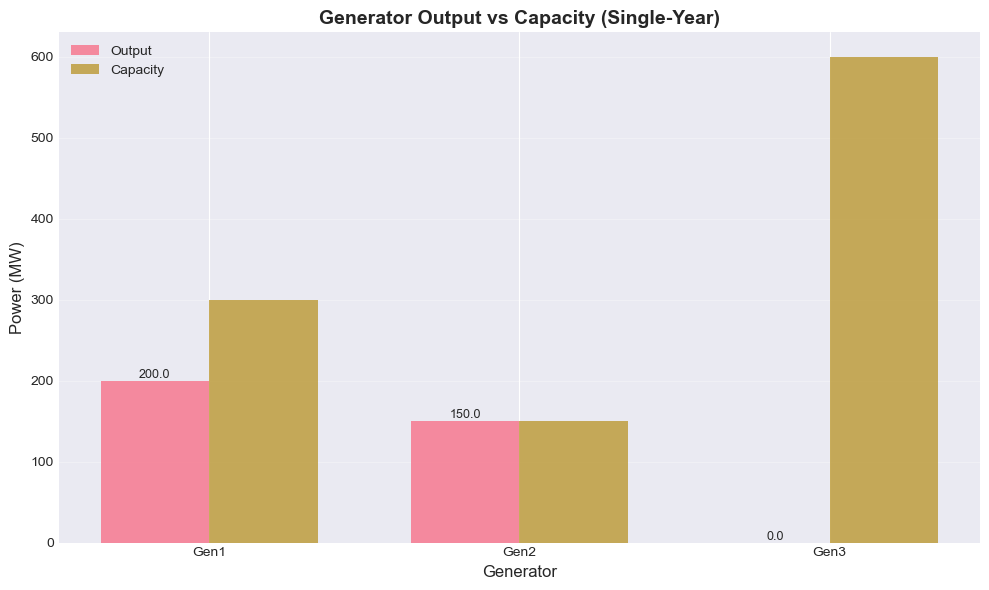

In [43]:
# 1. Generator Output vs Capacity Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Filter to only show generators with capacity > 0
active_gens = [gen for gen in gen_vars.keys() if generators[gen]['capacity'] > 0]
gen_outputs = [gen_vars[gen].x for gen in active_gens]
gen_capacities = [generators[gen]['capacity'] for gen in active_gens]

x = np.arange(len(active_gens))
width = 0.35

bars1 = ax.bar(x - width/2, gen_outputs, width, label='Output', alpha=0.8)
bars2 = ax.bar(x + width/2, gen_capacities, width, label='Capacity', alpha=0.8)

ax.set_xlabel('Generator', fontsize=12)
ax.set_ylabel('Power (MW)', fontsize=12)
ax.set_title('Generator Output vs Capacity (Single-Year)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(active_gens)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\victo\AppData\Local\Temp\ipykernel_24964\1199493657.py:64: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, [(bus_from, bus_to)], width=width,
C:\Users\victo\AppData\Local\Temp\ipykernel_24964\1199493657.py:64: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, [(bus_from, bus_to)], width=width,
C:\Users\victo\AppData\Local\Temp\ipykernel_24964\1199493657.py:64: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with

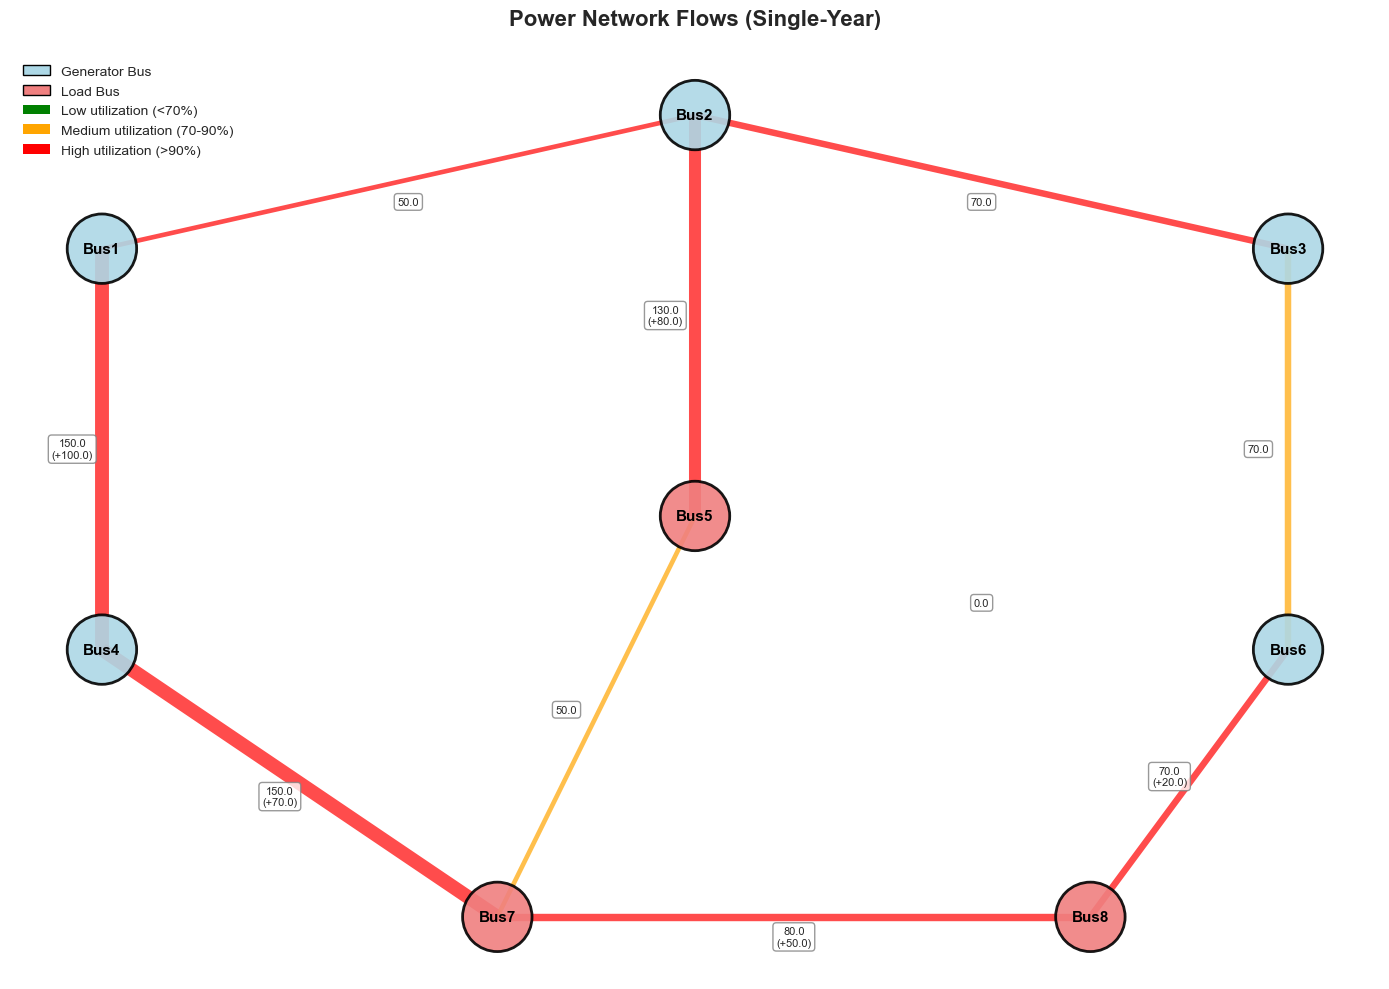

In [44]:
# 2. Network Diagram with Power Flows
fig, ax = plt.subplots(figsize=(14, 10))

# Create a graph with the actual line connections
G = nx.Graph()

# Add all buses as nodes
for bus in buses.keys():
    G.add_node(bus)

# Add edges based on actual line connections
for (bus_from, bus_to) in lines.keys():
    G.add_edge(bus_from, bus_to)

# Define positions for better visualization based on the network topology
# Layout arranged to show the network structure clearly
pos = {
    'Bus1': (0, 3),      # Top left
    'Bus2': (1.5, 3.5),  # Top center
    'Bus3': (3, 3),      # Top right
    'Bus4': (0, 1.5),    # Middle left
    'Bus5': (1.5, 2),    # Middle center
    'Bus6': (3, 1.5),    # Middle right
    'Bus7': (1, 0.5),    # Bottom left
    'Bus8': (2.5, 0.5)   # Bottom right
}

# Draw nodes with different colors for generators and loads
node_colors = []
node_sizes = []
for bus in G.nodes():
    if buses[bus]['type'] == 'generator':
        node_colors.append('lightblue')
        node_sizes.append(2500)
    else:
        node_colors.append('lightcoral')
        node_sizes.append(2500)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                       alpha=0.9, ax=ax, edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', ax=ax)

# Draw edges with thickness proportional to power flow
for (bus_from, bus_to), var in line_vars.items():
    flow = var.x
    capacity = lines[(bus_from, bus_to)]['capacity']
    upgrade = line_upgrade_vars[(bus_from, bus_to)].x
    
    # Edge width proportional to absolute flow
    width = max(1, abs(flow) / 15)
    
    # Color based on utilization
    utilization = abs(flow) / (capacity + upgrade) if (capacity + upgrade) > 0 else 0
    if utilization > 0.9:
        edge_color = 'red'
    elif utilization > 0.7:
        edge_color = 'orange'
    else:
        edge_color = 'green'
    
    # Draw arrow in direction of flow
    if abs(flow) > 0.1:  # Only draw if there's significant flow
        if flow > 0:
            nx.draw_networkx_edges(G, pos, [(bus_from, bus_to)], width=width, 
                                  edge_color=edge_color, alpha=0.7, 
                                  arrowsize=20, arrowstyle='->', ax=ax,
                                  connectionstyle='arc3,rad=0.1')
        else:
            nx.draw_networkx_edges(G, pos, [(bus_to, bus_from)], width=width, 
                                  edge_color=edge_color, alpha=0.7, 
                                  arrowsize=20, arrowstyle='->', ax=ax,
                                  connectionstyle='arc3,rad=0.1')
    
    # Add edge labels with flow values
    mid_x = (pos[bus_from][0] + pos[bus_to][0]) / 2
    mid_y = (pos[bus_from][1] + pos[bus_to][1]) / 2
    
    # Add small offset for readability
    offset_x = (pos[bus_to][1] - pos[bus_from][1]) * 0.05
    offset_y = -(pos[bus_to][0] - pos[bus_from][0]) * 0.05
    
    label_text = f'{abs(flow):.1f}'
    if upgrade > 0.1:
        label_text += f'\n(+{upgrade:.1f})'
    
    ax.text(mid_x + offset_x, mid_y + offset_y, label_text, 
            fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))

ax.set_title('Power Network Flows (Single-Year)', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', edgecolor='black', label='Generator Bus'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Load Bus'),
    Patch(facecolor='green', label='Low utilization (<70%)'),
    Patch(facecolor='orange', label='Medium utilization (70-90%)'),
    Patch(facecolor='red', label='High utilization (>90%)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

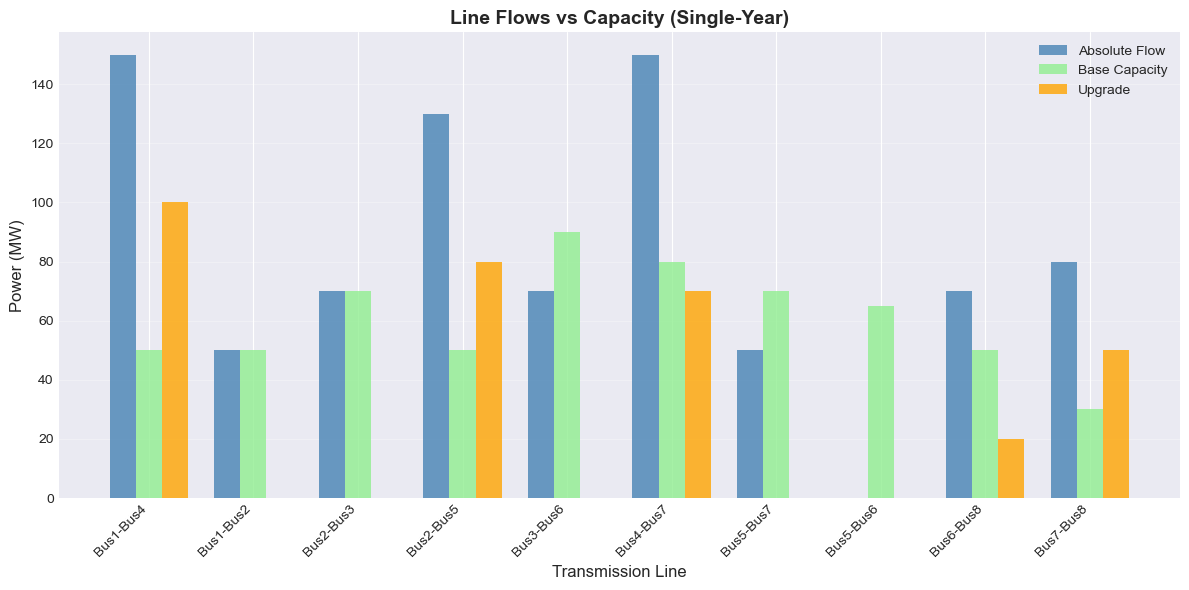

In [45]:
# 3. Line Flows vs Capacity (with Upgrades)
fig, ax = plt.subplots(figsize=(12, 6))

line_names = [f"{bf}-{bt}" for (bf, bt) in lines.keys()]
flows = [abs(line_vars[(bf, bt)].x) for (bf, bt) in lines.keys()]
base_caps = [lines[(bf, bt)]['capacity'] for (bf, bt) in lines.keys()]
upgrades = [line_upgrade_vars[(bf, bt)].x for (bf, bt) in lines.keys()]
total_caps = [base_caps[i] + upgrades[i] for i in range(len(base_caps))]

x = np.arange(len(line_names))
width = 0.25

bars1 = ax.bar(x - width, flows, width, label='Absolute Flow', alpha=0.8, color='steelblue')
bars2 = ax.bar(x, base_caps, width, label='Base Capacity', alpha=0.8, color='lightgreen')
bars3 = ax.bar(x + width, upgrades, width, label='Upgrade', alpha=0.8, color='orange')

ax.set_xlabel('Transmission Line', fontsize=12)
ax.set_ylabel('Power (MW)', fontsize=12)
ax.set_title('Line Flows vs Capacity (Single-Year)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(line_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

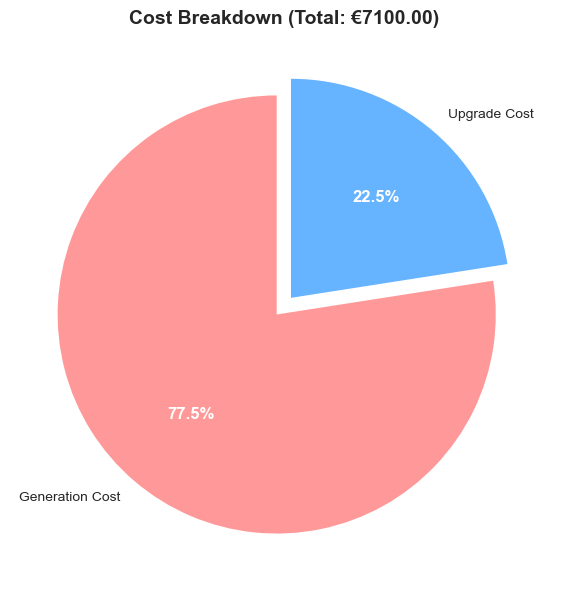

In [46]:
# 4. Cost Breakdown Pie Chart
total_gen_cost = sum(gen_vars[gen].x * generators[gen]['cost'] for gen in generators.keys())
total_upgrade_cost = sum(line_upgrade_vars[(bf, bt)].x * line_upgrade_cost for (bf, bt) in lines.keys())

fig, ax = plt.subplots(figsize=(8, 6))
costs = [total_gen_cost, total_upgrade_cost]
labels = ['Generation Cost', 'Upgrade Cost']
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0.05)

wedges, texts, autotexts = ax.pie(costs, labels=labels, autopct='%1.1f%%',
                                    colors=colors, explode=explode, startangle=90)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

ax.set_title(f'Cost Breakdown (Total: €{model.objVal:.2f})', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

# Part 2: Multi-Year Optimization (20 Years)

## Setup and Parameters

In [47]:
import gurobipy as gp
from gurobipy import GRB
import math
import random
# Cost for increasing line capacities
# -----------------------
# 20-year settings
# ------------------------
years = range(1, 21)  # Years 1..20

# 20-year load growth factors (2% per year)
load_growth_factor = {}
load_growth_factor = {y: random.uniform(0.5, 1.5) for y in years}


In [48]:

line_upgrade_cost = 5  # Cost per unit increase in line capacity

yearly_upgrade_budget = 250  # total money per year for all line upgrades

# Value of Lost Load (penalty for shedding)
VOLL = 1000  # €/MW or similar

# ------------------------
# Model
# ------------------------
model = gp.Model("electricity_system_20_years_with_budget")

# Generator outputs per year
gen_vars = {}
for gen, data in generators.items():
    for y in years:
        gen_vars[(gen, y)] = model.addVar(
            lb=0,
            ub=data['capacity'],
            name=f"GenOutput_{gen}_Y{y}"
        )

# Line flows per year (signed: + from bus_from to bus_to)
line_vars = {}
for (bus_from, bus_to), data in lines.items():
    for y in years:
        line_vars[(bus_from, bus_to, y)] = model.addVar(
            lb=-GRB.INFINITY,
            name=f"LineFlow_{bus_from}_{bus_to}_Y{y}"
        )

# Line capacity upgrades per line and year (incremental, cumulative over time)
line_upgrade_vars = {}
for (bus_from, bus_to), data in lines.items():
    for y in years:
        line_upgrade_vars[(bus_from, bus_to, y)] = model.addVar(
            lb=0,
            name=f"LineUpgrade_{bus_from}_{bus_to}_Y{y}"
        )

# Load shedding per load and year (unserved demand)
shed_vars = {}
for load, load_data in loads.items():
    for y in years:
        shed_vars[(load, y)] = model.addVar(
            lb=0,
            name=f"Shed_{load}_Y{y}"
        )

model.update()

# ------------------------
# Line capacity constraints
# For each year: |flow_y| <= base_capacity + sum(upgrades up to year y)
# ------------------------
for (bus_from, bus_to), data in lines.items():
    base_cap = data['capacity']
    for y in years:
        f = line_vars[(bus_from, bus_to, y)]
        # cumulative upgrade up to and including year y
        upgraded_cap = base_cap + gp.quicksum(
            line_upgrade_vars[(bus_from, bus_to, yy)]
            for yy in years if yy <= y
        )
        model.addConstr(
            f <= upgraded_cap,
            name=f"CapPos_{bus_from}_{bus_to}_Y{y}"
        )
        model.addConstr(
            f >= -upgraded_cap,
            name=f"CapNeg_{bus_from}_{bus_to}_Y{y}"
        )

# ------------------------
# Yearly budget constraints for upgrades
# sum_lines (upgrade_cost * upgrade_var[line,y]) <= yearly_upgrade_budget
# ------------------------
for y in years:
    model.addConstr(
        gp.quicksum(
            line_upgrade_cost * line_upgrade_vars[(bus_from, bus_to, y)]
            for (bus_from, bus_to) in lines.keys()
        ) <= yearly_upgrade_budget,
        name=f"UpgradeBudget_Y{y}"
    )

# ------------------------
# Power balance at each bus and year
# generation + net_import + shed = demand
# ------------------------
for y in years:
    for bus, bus_data in buses.items():
        generation = gp.LinExpr()
        net_import = gp.LinExpr()
        demand = gp.LinExpr()
        shed = gp.LinExpr()

        # Generation at this bus in year y
        for gen, gen_data in generators.items():
            if gen_data['bus'] == bus:
                generation += gen_vars[(gen, y)]

        # Net import from incident lines
        for (bus_from, bus_to), _ in lines.items():
            f = line_vars[(bus_from, bus_to, y)]
            if bus == bus_from:
                net_import += -f   # export if f > 0
            elif bus == bus_to:
                net_import += f    # import if f > 0

        # Demand and shedding at this bus in year y
        for load, load_data in loads.items():
            if load_data['bus'] == bus:
                base_demand = load_data['demand']
                demand += base_demand * load_growth_factor[y]
                shed += shed_vars[(load, y)]

        # Power balance
        model.addConstr(
            generation + net_import + shed == demand,
            name=f"PowerBalance_{bus}_Y{y}"
        )

# ------------------------
# Objective: generation cost + upgrade cost + shedding penalty
# ------------------------
gen_cost = gp.quicksum(
    gen_vars[(gen, y)] * generators[gen]['cost']
    for gen in generators
    for y in years
)

upgrade_cost_total = gp.quicksum(
    line_upgrade_cost * line_upgrade_vars[(bus_from, bus_to, y)]
    for (bus_from, bus_to) in lines.keys()
    for y in years
)

shed_cost = gp.quicksum(
    shed_vars[(load, y)] * VOLL
    for load in loads
    for y in years
)

model.setObjective(gen_cost + upgrade_cost_total + shed_cost, GRB.MINIMIZE)

# ------------------------
# Optimize
# ------------------------
model.optimize()

# ------------------------
# Results
# ------------------------
if model.status == GRB.OPTIMAL:
    print(f"\nTotal 20-year cost: {model.objVal:.2f}")

    print("\nYearly line upgrades:")
    for y in years:
        any_up = False
        for (bus_from, bus_to) in lines.keys():
            up = line_upgrade_vars[(bus_from, bus_to, y)].X
            if up > 1e-6:
                if not any_up:
                    print(f"\nYear {y}:")
                    any_up = True
                print(f"  Upgrade on line {bus_from} - {bus_to}: {up:.2f} MW")

    print("\nYearly effective line capacities (cumulative):")
    for y in years:
        print(f"\nYear {y}:")
        for (bus_from, bus_to), data in lines.items():
            base_cap = data['capacity']
            cum_upgrade = sum(
                line_upgrade_vars[(bus_from, bus_to, yy)].X
                for yy in years if yy <= y
            )
            eff_cap = base_cap + cum_upgrade
            print(f"  {bus_from} -> {bus_to}: {eff_cap:.2f} MW  (base {base_cap}, cum. upgrade {cum_upgrade:.2f})")

    print("\nYearly generation (non-zero):")
    for y in years:
        print(f"\nYear {y}:")
        for gen in generators.keys():
            val = gen_vars[(gen, y)].X
            if abs(val) > 1e-6:
                print(f"  {gen}: {val:.2f} MW")

    print("\nYearly load shedding (if any):")
    for y in years:
        any_shed = False
        for load in loads.keys():
            s = shed_vars[(load, y)].X
            if s > 1e-6:
                if not any_shed:
                    print(f"\nYear {y}:")
                    any_shed = True
                print(f"  Shed at {load}: {s:.2f} MW")

else:
    print("Model not optimal. Status code:", model.status)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 5600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 580 rows, 560 columns and 5360 nonzeros
Model fingerprint: 0xe9a4baac

CPU model: AMD Ryzen 5 5600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 580 rows, 560 columns and 5360 nonzeros
Model fingerprint: 0xe9a4baac


Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [2e+02, 6e+02]
  RHS range        [3e+01, 3e+02]
Presolve removed 141 rows and 180 columns
Presolve time: 0.02s
Presolved: 439 rows, 380 columns, 5926 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
  Matrix range     [1e+00, 5e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [2e+02, 6e+02]
  RHS range        [3e+01, 3e+02]
Presolve removed 141 rows and 180 columns
Presolve time: 0.02s
Presolved: 439 rows, 380 columns, 5926 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     247    3.5655414e+05   0.000000e+00   0.000000e+00      0s

Solved in 247 iterations and 0.03 seconds (0.01 work units)
Optimal objective  3.565541392e+05

Total 20-year cost: 356554.14

Yearly line upgrades:

Year 1:
 

## Model Formulation and Solution

---

## Visualizations: Multi-Year Results

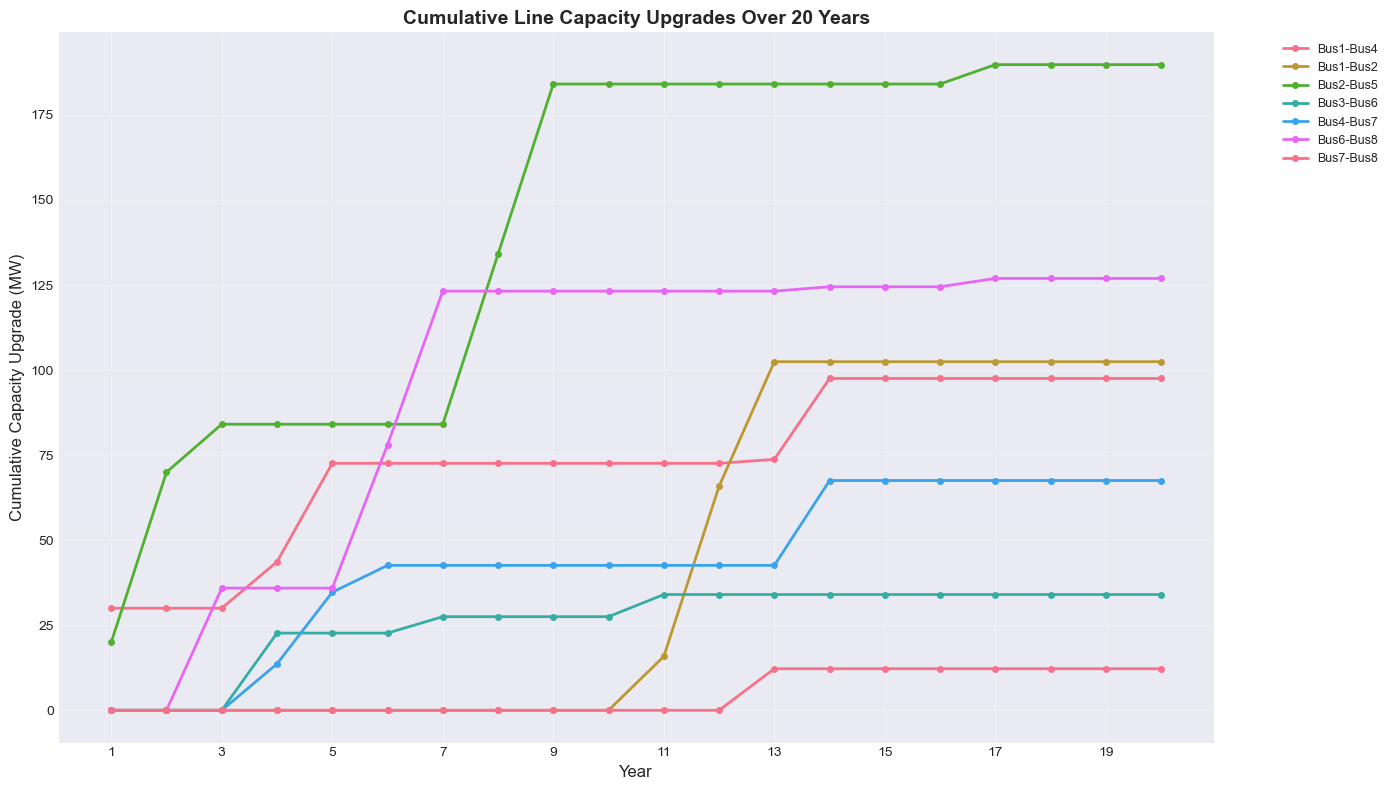

In [49]:
# 1. Cumulative Line Capacity Upgrades Over Time
fig, ax = plt.subplots(figsize=(14, 8))

for (bus_from, bus_to) in lines.keys():
    cumulative_upgrades = []
    for y in years:
        cum = sum(line_upgrade_vars[(bus_from, bus_to, yy)].X for yy in years if yy <= y)
        cumulative_upgrades.append(cum)
    
    # Only plot lines that have upgrades
    if max(cumulative_upgrades) > 0.1:
        ax.plot(list(years), cumulative_upgrades, marker='o', 
               label=f'{bus_from}-{bus_to}', linewidth=2, markersize=4)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative Capacity Upgrade (MW)', fontsize=12)
ax.set_title('Cumulative Line Capacity Upgrades Over 20 Years', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 21, 2))

plt.tight_layout()
plt.show()

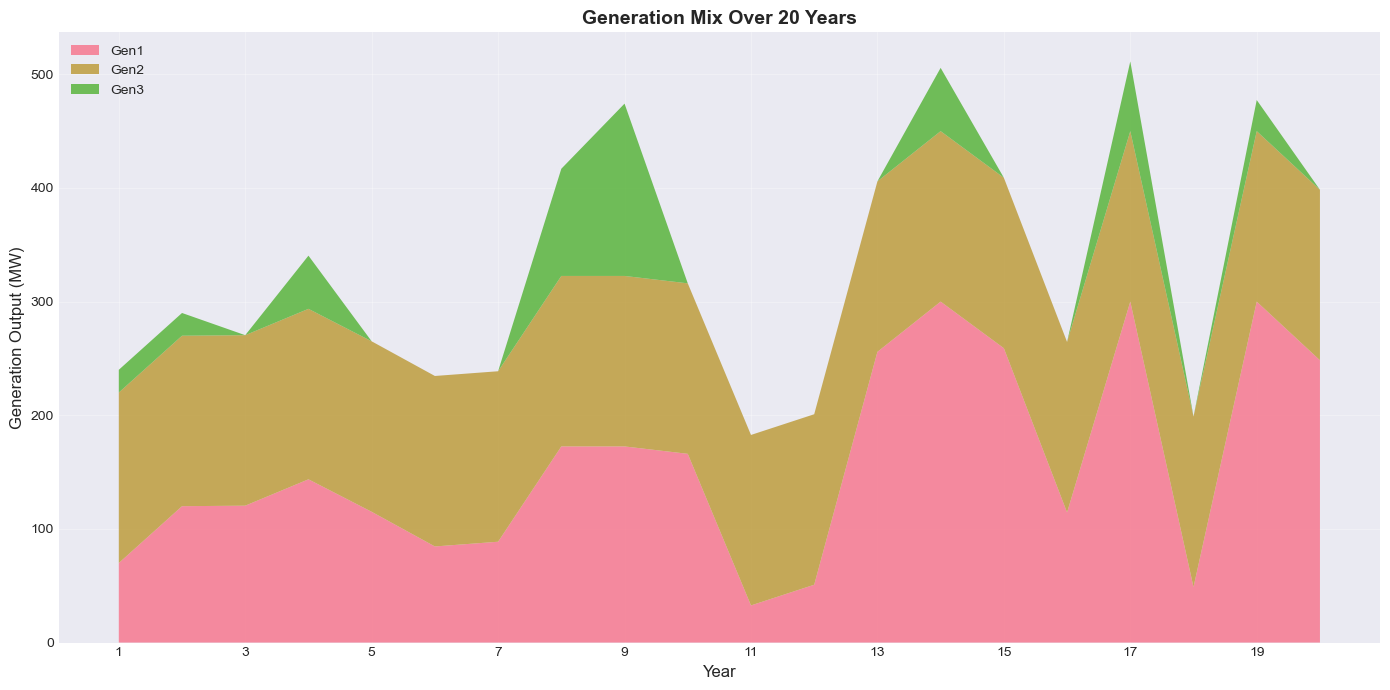

In [50]:
# 2. Generation Mix Over Time (Stacked Area Chart)
fig, ax = plt.subplots(figsize=(14, 7))

# Filter to only show generators with capacity > 0
active_gens = [gen for gen in generators.keys() if generators[gen]['capacity'] > 0]

# Prepare data for stacked area chart
gen_data = {gen: [] for gen in active_gens}
for y in years:
    for gen in active_gens:
        gen_data[gen].append(gen_vars[(gen, y)].X)

# Create stacked area chart
ax.stackplot(list(years), *[gen_data[gen] for gen in active_gens],
            labels=active_gens, alpha=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Generation Output (MW)', fontsize=12)
ax.set_title('Generation Mix Over 20 Years', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 21, 2))

plt.tight_layout()
plt.show()

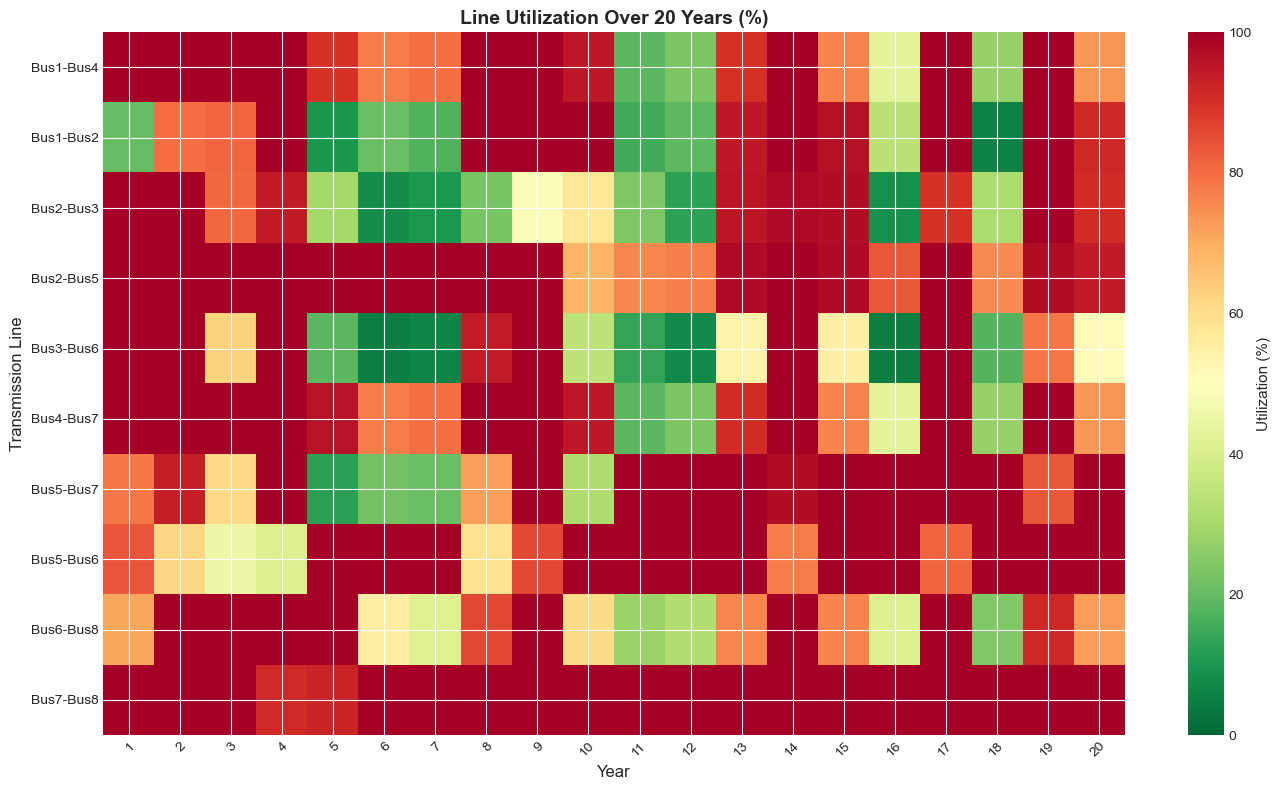

In [51]:
# 3. Line Utilization Heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare utilization matrix
line_labels = [f"{bf}-{bt}" for (bf, bt) in lines.keys()]
utilization_matrix = np.zeros((len(lines), len(years)))

for i, (bus_from, bus_to) in enumerate(lines.keys()):
    base_cap = lines[(bus_from, bus_to)]['capacity']
    for j, y in enumerate(years):
        flow = abs(line_vars[(bus_from, bus_to, y)].X)
        cum_upgrade = sum(line_upgrade_vars[(bus_from, bus_to, yy)].X for yy in years if yy <= y)
        total_cap = base_cap + cum_upgrade
        utilization = (flow / total_cap * 100) if total_cap > 0 else 0
        utilization_matrix[i, j] = utilization

# Create heatmap
im = ax.imshow(utilization_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=100)

ax.set_xticks(np.arange(len(years)))
ax.set_yticks(np.arange(len(line_labels)))
ax.set_xticklabels(years)
ax.set_yticklabels(line_labels)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Transmission Line', fontsize=12)
ax.set_title('Line Utilization Over 20 Years (%)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Utilization (%)', fontsize=11)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

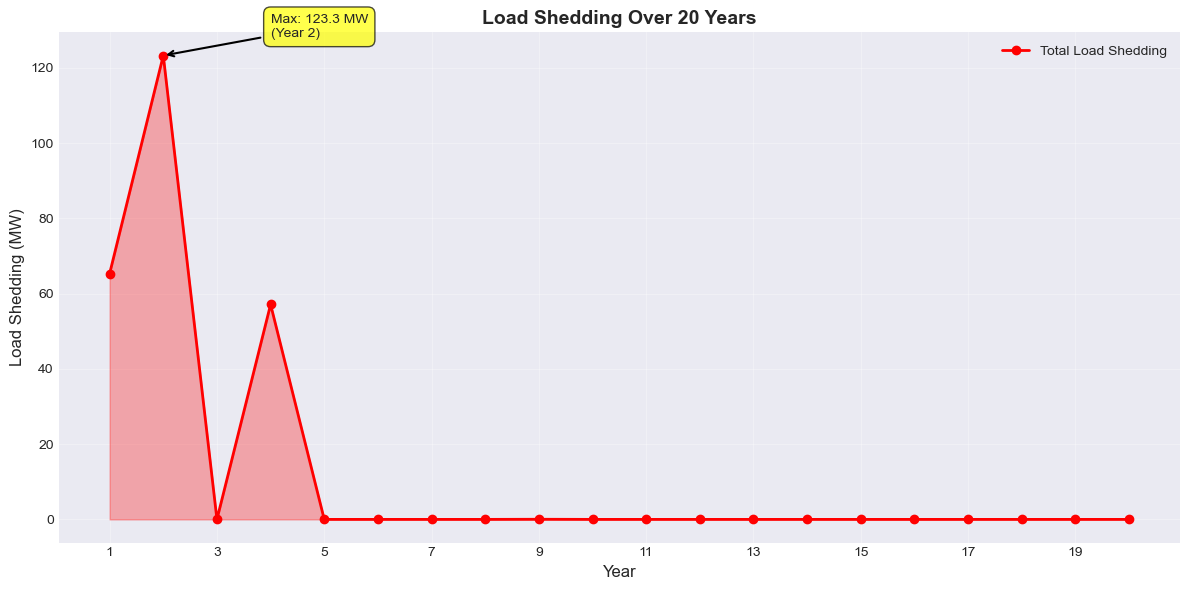

In [52]:
# 4. Load Shedding Over Time
fig, ax = plt.subplots(figsize=(12, 6))

shed_by_year = []
for y in years:
    total_shed = sum(shed_vars[(load, y)].X for load in loads.keys())
    shed_by_year.append(total_shed)

ax.plot(list(years), shed_by_year, marker='o', linewidth=2, markersize=6, 
        color='red', label='Total Load Shedding')
ax.fill_between(list(years), shed_by_year, alpha=0.3, color='red')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Load Shedding (MW)', fontsize=12)
ax.set_title('Load Shedding Over 20 Years', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 21, 2))
ax.legend(fontsize=10)

# Add annotation if there's significant shedding
max_shed = max(shed_by_year)
if max_shed > 0.1:
    max_year = shed_by_year.index(max_shed) + 1
    ax.annotate(f'Max: {max_shed:.1f} MW\n(Year {max_year})',
               xy=(max_year, max_shed), xytext=(max_year+2, max_shed+5),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
               fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

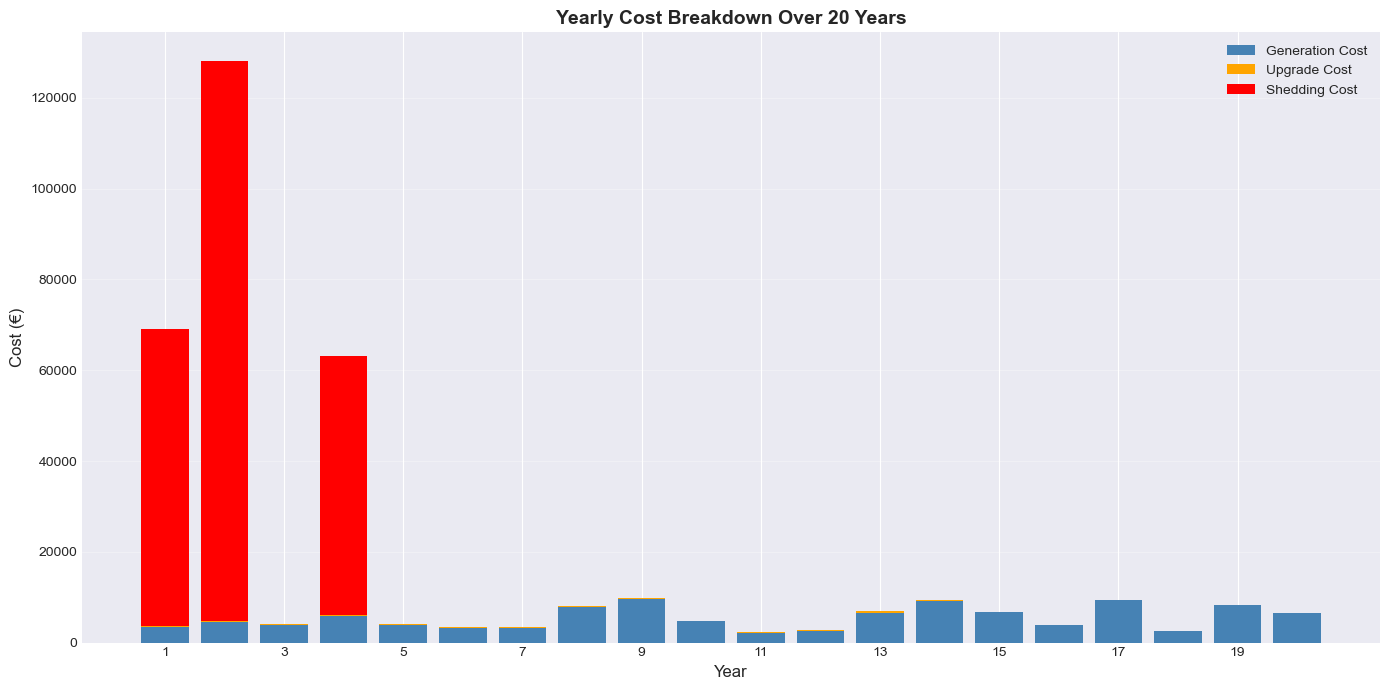

In [53]:
# 5. Yearly Cost Breakdown (Stacked Bar Chart)
fig, ax = plt.subplots(figsize=(14, 7))

yearly_gen_cost = []
yearly_upgrade_cost = []
yearly_shed_cost = []

for y in years:
    gen_cost = sum(gen_vars[(gen, y)].X * generators[gen]['cost'] for gen in generators.keys())
    upgrade_cost = sum(line_upgrade_vars[(bf, bt, y)].X * line_upgrade_cost for (bf, bt) in lines.keys())
    shed_cost = sum(shed_vars[(load, y)].X * VOLL for load in loads.keys())
    
    yearly_gen_cost.append(gen_cost)
    yearly_upgrade_cost.append(upgrade_cost)
    yearly_shed_cost.append(shed_cost)

x = np.array(list(years))
width = 0.8

p1 = ax.bar(x, yearly_gen_cost, width, label='Generation Cost', color='steelblue')
p2 = ax.bar(x, yearly_upgrade_cost, width, bottom=yearly_gen_cost, 
           label='Upgrade Cost', color='orange')
p3 = ax.bar(x, yearly_shed_cost, width, 
           bottom=np.array(yearly_gen_cost) + np.array(yearly_upgrade_cost),
           label='Shedding Cost', color='red')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cost (€)', fontsize=12)
ax.set_title('Yearly Cost Breakdown Over 20 Years', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(1, 21, 2))

plt.tight_layout()
plt.show()

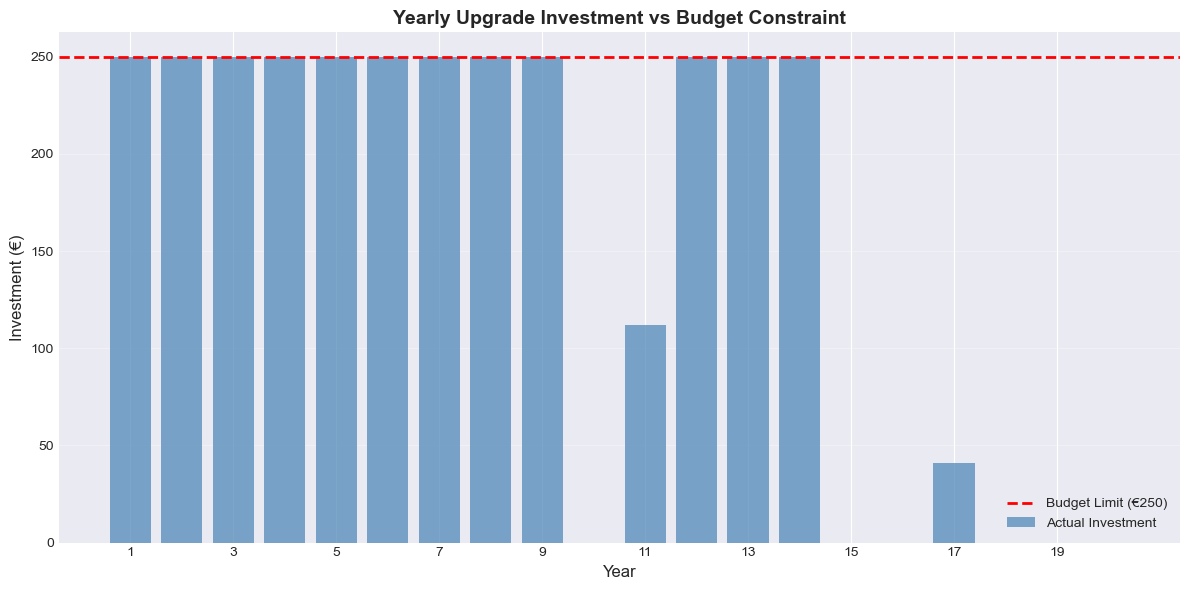

In [54]:
# 6. Yearly Upgrade Investment vs Budget
fig, ax = plt.subplots(figsize=(12, 6))

yearly_investments = []
for y in years:
    investment = sum(line_upgrade_vars[(bf, bt, y)].X * line_upgrade_cost for (bf, bt) in lines.keys())
    yearly_investments.append(investment)

ax.bar(list(years), yearly_investments, color='steelblue', alpha=0.7, label='Actual Investment')
ax.axhline(y=yearly_upgrade_budget, color='red', linestyle='--', linewidth=2, label=f'Budget Limit (€{yearly_upgrade_budget})')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Investment (€)', fontsize=12)
ax.set_title('Yearly Upgrade Investment vs Budget Constraint', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(1, 21, 2))

plt.tight_layout()
plt.show()

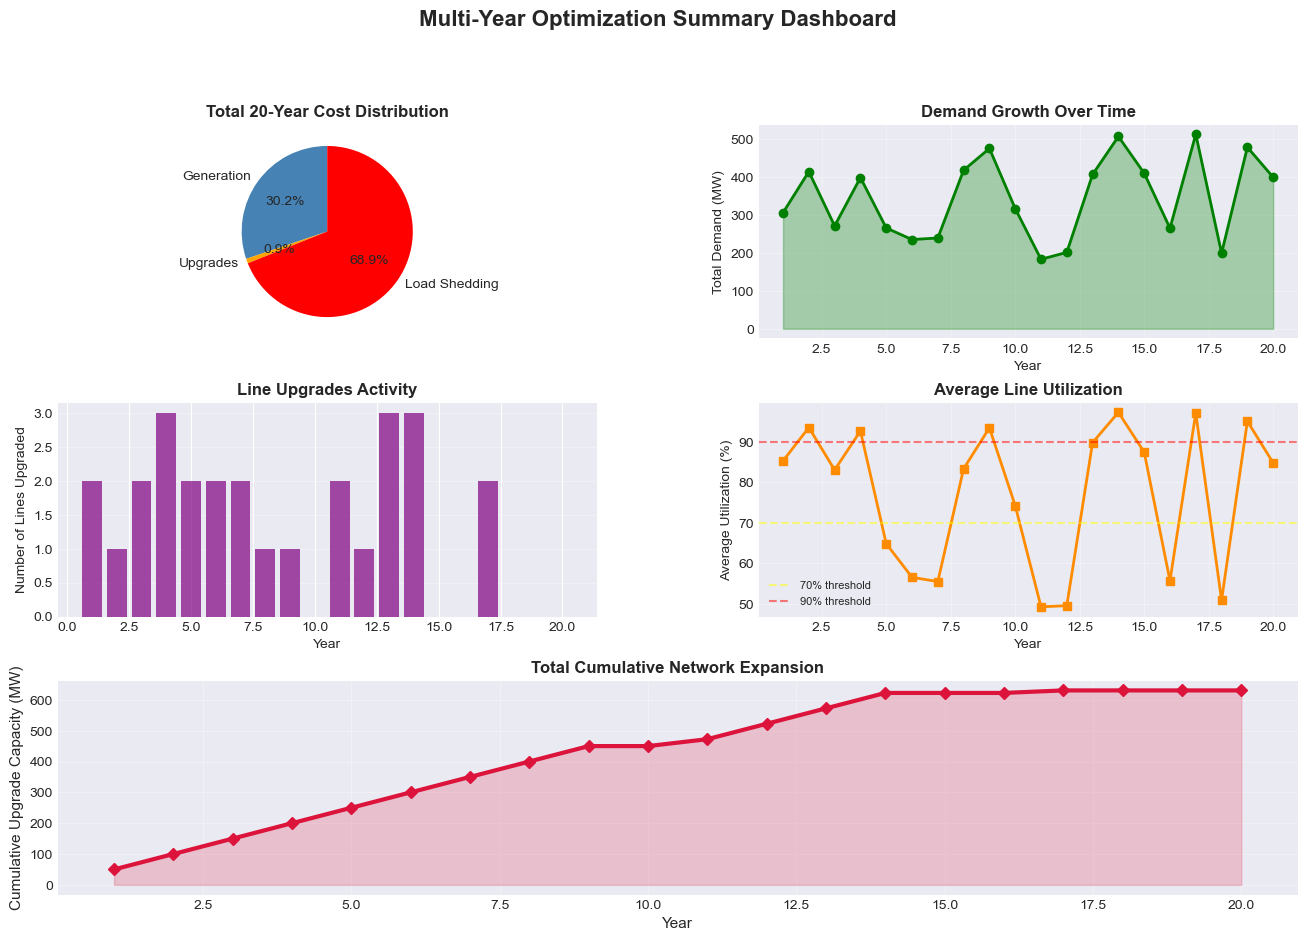

In [55]:
# 7. Summary Dashboard - Multi-Year Overview
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Subplot 1: Total costs by category
ax1 = fig.add_subplot(gs[0, 0])
total_gen = sum(yearly_gen_cost)
total_upgrade = sum(yearly_upgrade_cost)
total_shed = sum(yearly_shed_cost)
categories = ['Generation', 'Upgrades', 'Load Shedding']
values = [total_gen, total_upgrade, total_shed]
colors_pie = ['steelblue', 'orange', 'red']
ax1.pie(values, labels=categories, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax1.set_title('Total 20-Year Cost Distribution', fontweight='bold')

# Subplot 2: Demand growth over time
ax2 = fig.add_subplot(gs[0, 1])
total_demand_by_year = []
for y in years:
    total_demand = sum(loads[load]['demand'] * load_growth_factor[y] for load in loads.keys())
    total_demand_by_year.append(total_demand)
ax2.plot(list(years), total_demand_by_year, marker='o', color='green', linewidth=2)
ax2.fill_between(list(years), total_demand_by_year, alpha=0.3, color='green')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total Demand (MW)')
ax2.set_title('Demand Growth Over Time', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Subplot 3: Number of line upgrades per year
ax3 = fig.add_subplot(gs[1, 0])
upgrades_per_year = []
for y in years:
    count = sum(1 for (bf, bt) in lines.keys() if line_upgrade_vars[(bf, bt, y)].X > 0.1)
    upgrades_per_year.append(count)
ax3.bar(list(years), upgrades_per_year, color='purple', alpha=0.7)
ax3.set_xlabel('Year')
ax3.set_ylabel('Number of Lines Upgraded')
ax3.set_title('Line Upgrades Activity', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Average line utilization per year
ax4 = fig.add_subplot(gs[1, 1])
avg_utilization_by_year = []
for y in years:
    utils = []
    for (bf, bt) in lines.keys():
        base_cap = lines[(bf, bt)]['capacity']
        flow = abs(line_vars[(bf, bt, y)].X)
        cum_upgrade = sum(line_upgrade_vars[(bf, bt, yy)].X for yy in years if yy <= y)
        total_cap = base_cap + cum_upgrade
        if total_cap > 0:
            utils.append(flow / total_cap * 100)
    avg_utilization_by_year.append(np.mean(utils) if utils else 0)

ax4.plot(list(years), avg_utilization_by_year, marker='s', color='darkorange', linewidth=2)
ax4.axhline(y=70, color='yellow', linestyle='--', alpha=0.5, label='70% threshold')
ax4.axhline(y=90, color='red', linestyle='--', alpha=0.5, label='90% threshold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Average Utilization (%)')
ax4.set_title('Average Line Utilization', fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# Subplot 5: Cumulative upgrade capacity
ax5 = fig.add_subplot(gs[2, :])
cumulative_total_upgrades = []
for y in years:
    total = sum(sum(line_upgrade_vars[(bf, bt, yy)].X for yy in years if yy <= y) 
                for (bf, bt) in lines.keys())
    cumulative_total_upgrades.append(total)

ax5.plot(list(years), cumulative_total_upgrades, marker='D', color='crimson', 
         linewidth=3, markersize=6)
ax5.fill_between(list(years), cumulative_total_upgrades, alpha=0.2, color='crimson')
ax5.set_xlabel('Year', fontsize=11)
ax5.set_ylabel('Cumulative Upgrade Capacity (MW)', fontsize=11)
ax5.set_title('Total Cumulative Network Expansion', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)

fig.suptitle('Multi-Year Optimization Summary Dashboard', fontsize=16, fontweight='bold', y=0.995)

plt.show()